In [1]:
import torchvision.datasets as dsets
import matplotlib.pyplot as plt
import numpy as np

mnist_trainset = dsets.MNIST(root='./data', train=True, download = True)
mnist_testset = dsets.MNIST(root='./data', train=False, download = True)
print(len(mnist_trainset))
print(len(mnist_testset))

60000
10000


Функции активаций, их производные и функция потерь, а также производная функции потерь с учетом того, что функция активации последнего слоя - softmax.

In [0]:
def CrossEntropyLoss(x, class_x, reduction = 'none'):
  output = []
  for i, row in enumerate(x):
    sum = -1 * row[class_x[i]] + np.log(np.exp(row).sum())
    output.append(sum)

  if reduction == 'none':
    ans = np.asarray(output).reshape(1, x.shape[0])
  elif reduction == 'sum':
    ans = np.asarray(output).sum()
  elif reduction == 'mean':
    ans = np.asarray(output).mean()

  return ans

def d_CrossEntropyLoss(x, labels):
  output = []
  for i, row in enumerate(x):
    row[labels[i]] -= 1
    output.append(row)

  return np.asarray(output).reshape(x.shape[0], x.shape[1])

def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

def d_sigmoid(x):
  return sigmoid(x) * (1 - sigmoid(x))

def ReLU(x):
  return x * (x > 0)

def d_ReLU(x):
  return 1. * (x > 0)

def softmax(x):
  exp = np.exp(x)
  return exp/np.sum(exp, axis = 1, keepdims = True)

def d_softmax(x):
  return softmax(x) * (1 - softmax(x))

def default(x):
  return x

def d_default(x):
  return x

Каждый объект класса Layer хранит в себе функцию активации и производную для соответствующей функции активации.

In [0]:
class Layer(object):
  def __init__(self, function, derivative_func):

    self.function = function
    self.derivative = derivative_func

  def activate(self, arr):
    return self.function(arr)
    
  def derivate(self, arr):
    return self.derivative(arr)


Класс нейронной сети. Входные параметры - 2 списка, lr(шаг обучения) и batch_size(размер батча).

Первый список вида [N, M, ..., Q]. N - кол-во нейронов в первом(входном) слое, M - во втором, ..., Q - в выходном слое.

Второй список вида ['sigmoid', 'relu', ..., 'softmax']. Названия соответствующих функций активаций для каждого слоя, начиная с первого скрытого.

В данной реализации - функция активации последнего слоя обязательно softmax.

In [0]:
class Network(object):

  def __init__(self, layers, functions, lr = 0.01, batch_size = 8):

    self.cntOfLayers = len(layers)
    self.batch_size = batch_size
    self.layers = []
    self.weights = []
    self.biases = []
    self.lr = lr
    self.loss = []

    #назначаем слоям функции активации и соответствующие производные функций активации
    self.layers.append(Layer(default, d_default))
    for i in range(self.cntOfLayers - 1):
      if functions[i] == 'sigmoid':
        func = sigmoid
        d_func = d_sigmoid
      elif functions[i] == 'relu':
        func = ReLU
        d_func = d_ReLU
      elif functions[i] == 'softmax':
        func = softmax
        d_func = d_softmax
      elif functions[i] == 'default':
        func = default
        d_func = d_default

      self.layers.append(Layer(func, d_func))
    #Создаем матрицы весов. Размерность каждой матрицы NxM, где N - кол-во нейронов "слева", а M - кол-во нейронов "справа"
    #bias'ы - имеют размерность 1 X N, где N - кол-во нейронов в скрытом слое, начиная с первого скрытого
    for i in range(self.cntOfLayers - 1):
      self.weights.append(np.random.normal(0, 0.1, [layers[i], layers[i + 1]]))
      self.biases.append(np.zeros((1, layers[i + 1])))


  def find_length(self, batch):

    length = self.batch_size

    if batch < self.batch_size:
      length = batch

    return length

  def train(self, input_data, input_labels):

      iteration = 0
      while iteration < len(input_data):

        # batch input
        inputs_batch = input_data[iteration:iteration+self.batch_size]
        labels_batch = input_labels[iteration:iteration+self.batch_size]

        length = self.find_length(len(labels_batch))

        labels = np.array(labels_batch).reshape(length, 1)

        #forward pass
        self.h = [] #значения слоев при прямом проходе(forward)
        self.h2 = [] #значения слоев при проходе обратно(backward)
        self.h.append(inputs_batch)
        self.h2.append(inputs_batch)

        for layer in range(self.cntOfLayers - 1):
          n_in = np.dot(inputs_batch, self.weights[layer]) + self.biases[layer]

          n_out = self.layers[layer + 1].activate(n_in)
          if(layer == self.cntOfLayers - 2): 
            self.loss.append(CrossEntropyLoss(n_out, labels, 'mean'))
            n_out = d_CrossEntropyLoss(n_out, labels)
          
          inputs_batch = n_out
          self.h.append(n_out)
          self.h2.append(n_out)

        #backward pass
        for layer in range(self.cntOfLayers - 2, 0, -1):
          res = np.dot(self.h2[layer + 1], self.weights[layer].T) + self.biases[layer - 1]
          self.h2[layer] = res * (self.layers[layer].derivate(self.h[layer]))

        #weights update
        for layer in range(self.cntOfLayers - 2, -1, -1):
          self.weights[layer] = self.weights[layer] - self.lr * np.dot(self.h[layer].T, self.h2[layer + 1]) / length
          self.biases[layer] = self.biases[layer] - self.lr * np.sum(self.h2[layer + 1], axis = 0, keepdims = True) / length

        iteration += self.batch_size

      print('loss =', self.loss[len(self.loss) - 1])

  def predict(self, item):
    for layer in range(self.cntOfLayers - 1):
      n_in = np.dot(item, self.weights[layer]) + self.biases[layer]

      n_out = self.layers[layer + 1].activate(n_in)

      item = n_out

    return softmax(n_out).argmax()

  def eval(self, x_test, y_test):
    true = 0
    false = 0
    loss = []
    iteration = 0
    N = self.h[self.cntOfLayers - 1].shape[1]
    conf_matrix = np.zeros((N, N))
    while iteration < len(x_test):

      # batch input
      inputs_batch = x_test[iteration:iteration+self.batch_size]
      labels_batch = y_test[iteration:iteration+self.batch_size]

      length = self.find_length(len(labels_batch))
    
      labels = np.array(labels_batch).reshape(length, 1)

      for i, x in enumerate(inputs_batch):

        pred = self.predict(x)
        ans = labels[i]

        conf_matrix[ans][pred] += 1

        if pred == ans:
          true += 1
        else:
          false +=1

      #feed forward
      for layer in range(self.cntOfLayers - 1):
        n_in = np.dot(inputs_batch, self.weights[layer]) + self.biases[layer]

        n_out = self.layers[layer + 1].activate(n_in)

        inputs_batch = n_out

      loss.append(CrossEntropyLoss(n_out, labels, 'mean'))

      iteration += self.batch_size

    for i, _ in enumerate(conf_matrix):
      conf_matrix[i] = conf_matrix[i] / np.sum(conf_matrix[i])

    return loss, true / (true + false), conf_matrix





Обучение модели


In [22]:
net = Network(np.array([784, 512, 256, 10]), np.array(['sigmoid', 'relu', 'softmax']), 0.01, 16)

x, y = mnist_trainset.data, mnist_trainset.targets
n_epochs = 4
x = x.numpy().reshape(-1, 28*28) / 255
y = y.numpy()

for i in range(n_epochs):
  net.train(x, y)
  print('after epoch =', i)

loss = 1.535911022320795
after epoch = 0
loss = 1.5064155929287721
after epoch = 1
loss = 1.4953816628879326
after epoch = 2
loss = 1.4899075228910035
after epoch = 3


Оценка работы модели

In [23]:
x, y = mnist_testset.data, mnist_testset.targets
x = x.numpy().reshape(-1, 28*28) / 255
y = y.numpy()

loss, acc, conf_matrix = net.eval(x, y)
print(acc)

0.9332


Loss на обучающей выборке.


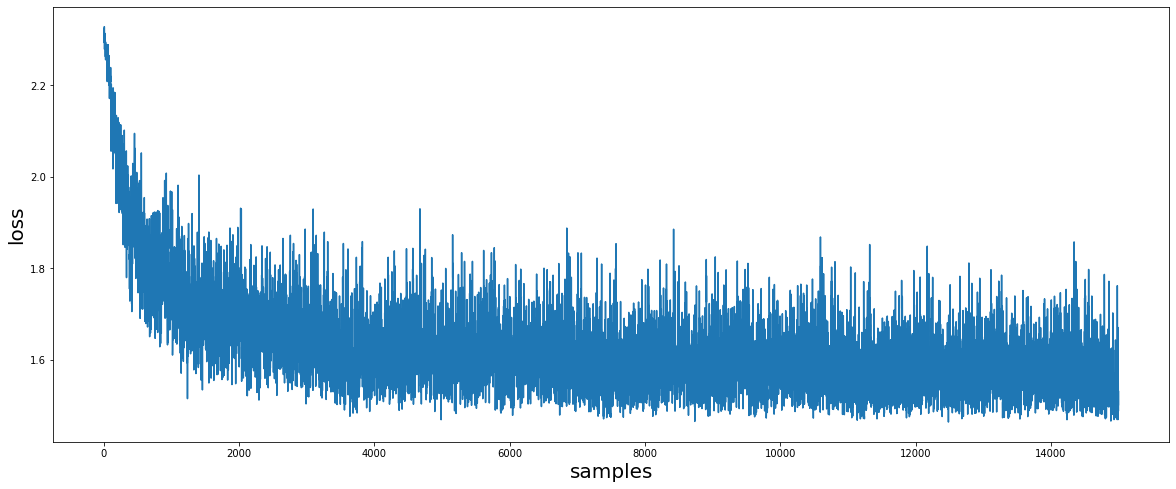

In [24]:
plt.figure(figsize=(20, 8))
plt.plot(net.loss)
plt.xlabel('samples', fontsize=20)
plt.ylabel('loss', fontsize=20)
plt.show();

Loss на тестовой выборке.

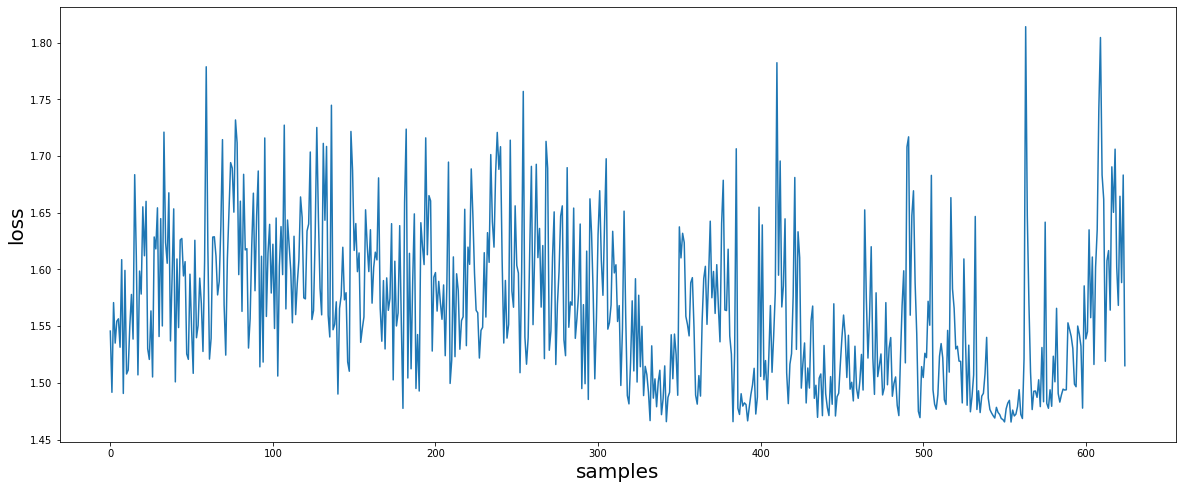

In [25]:
plt.figure(figsize=(20, 8))
plt.plot(loss)
plt.xlabel('samples', fontsize=20)
plt.ylabel('loss', fontsize=20)
plt.show();

Теперь посмотрим на confusion matrix.

На пересечениях строк и столбцов кол-во объектов, которым был предсказан класс от 0 до 9(по строкам) и которые имели свой истинный класс от 0 до 9(по столбцам).

Соответственно, по диагонали располагается кол-во объектов, для которых модель верно предсказала их классы.

In [29]:
for row in conf_matrix:
  print(row.round(3))

[0.943 0.    0.011 0.    0.003 0.009 0.014 0.003 0.007 0.011]
[0.    0.951 0.009 0.001 0.003 0.004 0.003 0.012 0.01  0.007]
[0.001 0.002 0.936 0.015 0.004 0.005 0.005 0.026 0.006 0.001]
[0.001 0.002 0.014 0.919 0.    0.026 0.    0.007 0.022 0.01 ]
[0.    0.001 0.013 0.    0.923 0.008 0.01  0.01  0.01  0.024]
[0.003 0.001 0.001 0.021 0.    0.93  0.017 0.001 0.017 0.007]
[0.006 0.004 0.01  0.001 0.009 0.007 0.951 0.    0.01  0.   ]
[0.001 0.001 0.005 0.006 0.001 0.003 0.001 0.973 0.004 0.003]
[0.001 0.007 0.02  0.012 0.003 0.02  0.002 0.002 0.928 0.004]
[0.    0.001 0.004 0.01  0.04  0.009 0.    0.046 0.009 0.88 ]


Ниже можно посмотреть какие ошибки допускает модель при классификации.

In [34]:
for i, row in enumerate(conf_matrix):
  row[i] = 0
  print('Цифру', i, 'модель чаще всего путает с цифрой', row.argmax(), 'ошибок', row.max().round(3), '% от общего кол-ва цифр ', i)


Цифру 0 модель чаще всего путает с цифрой 6 ошибок 0.014 % от общего кол-ва цифр  0
Цифру 1 модель чаще всего путает с цифрой 7 ошибок 0.012 % от общего кол-ва цифр  1
Цифру 2 модель чаще всего путает с цифрой 7 ошибок 0.026 % от общего кол-ва цифр  2
Цифру 3 модель чаще всего путает с цифрой 5 ошибок 0.026 % от общего кол-ва цифр  3
Цифру 4 модель чаще всего путает с цифрой 9 ошибок 0.024 % от общего кол-ва цифр  4
Цифру 5 модель чаще всего путает с цифрой 3 ошибок 0.021 % от общего кол-ва цифр  5
Цифру 6 модель чаще всего путает с цифрой 2 ошибок 0.01 % от общего кол-ва цифр  6
Цифру 7 модель чаще всего путает с цифрой 3 ошибок 0.006 % от общего кол-ва цифр  7
Цифру 8 модель чаще всего путает с цифрой 2 ошибок 0.02 % от общего кол-ва цифр  8
Цифру 9 модель чаще всего путает с цифрой 7 ошибок 0.046 % от общего кол-ва цифр  9
